# Example 3: how to use random retrieval to plot distributions

In [1]:
import sys
from sgqlc.operation import Operation
from srgssr_publication_data_api import pdp_schema as schema
from srgssr_publication_data_api import client

## 1. Set the API endpoint
Ensure the endpoint is set to the PDP (FARO) schema on INT

In [2]:
%set_env PDP_API=https://graphql-api.pdp.dev.srgssr.ch/graphql

env: PDP_API=https://graphql-api.pdp.int.srgssr.ch/graphql


In [3]:
# fetch environment variable with PDP endpoint API address
! echo "${PDP_API}"

https://graphql-api.pdp.int.srgssr.ch/graphql


## 2. Show available queries

In [4]:
schema.Query

type Query {
  faroProgramPage(first: Int!, after: String): FaroProgramPage!
  faroPrograms(ids: [String!]!): [FaroProgram]!
  randomFaroPrograms: [FaroProgram!]!
  faroItemPage(first: Int!, after: String): FaroItemPage!
  faroItems(ids: [String!]!): [FaroItem]!
  faroItemsByPlayUrn(urns: [String!]!): [FaroItem]!
  faroItemsByPlayUrnGraphDb(urns: [String!]!): [FaroItem]!
  randomFaroItems: [FaroItem!]!
}

## 3. Configure the query operation

In [5]:
op = Operation(schema.Query)

In [6]:
faro = op.random_faro_items()

In [7]:
# return the current query
op

query {
  randomFaroItems {
    id
    programId
    itemNr
    rights
    isPoisonous
    playMedias {
      id
      title
      urn
      description
    }
    mediaUrns
    playLinks
    descriptorPaths
    program {
      id
      bu
      mediaType
      episodeIds
      sTit
      sDatStart
      sGef
      pTit
      department
      workgroup
      seriesNr
    }
    bTit
    recordingDate
    ingestDate
    prodTypes
    producer
    licenseHolder
    abs
    fdes
    sportDoc {
      season
      sportEventPaths
      sportPaths
    }
    webCmsIds
  }
}

## 4. Select fields of interest

In [8]:
faro.id()
faro.b_tit()
faro.producer()
faro.program.s_dat_start()
faro.sport_doc()
faro.web_cms_ids()

webCmsIds

In [9]:
op

query {
  randomFaroItems {
    id
    bTit
    producer
    program {
      sDatStart
    }
    sportDoc {
      season
      sportEventPaths
      sportPaths
    }
    webCmsIds
  }
}

## 5. Retrieve the data

In [10]:
# constants
page_requests = 100

In [11]:
# init results
results = []

In [12]:
# download data
from tqdm.notebook import tnrange
for i in tnrange(page_requests, desc="Downloading data"):
    # query page
    data = client.run_query(op)
    
    # add results
    results += (op + data).random_faro_items

In [13]:
print(f'INFO - Retrieved {len(results):,} FaroItems')

INFO - Retrieved 1,000 FaroItems


In [14]:
results[0]

FaroItem(id='31135c2d-b305-4575-aba6-e3d681adbc6a', b_tit='Hotelleriesuisse GR', producer='RTR', program=FaroProgram(s_dat_start='2018-02-02'), sport_doc=FaroSportDoc(season=None, sport_event_paths=[], sport_paths=[]), web_cms_ids=['e504d662-04ab-4a9c-85b1-6fbe66638aa0'])

## 6. Plot the year distribution of first display

In [15]:
results[0].program.s_dat_start

'2018-02-02'

In [16]:
from collections import Counter
from datetime import date

# count year occurrences
c = Counter(date.fromisoformat(x.program.s_dat_start).year 
            for x in results if x.program.s_dat_start)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

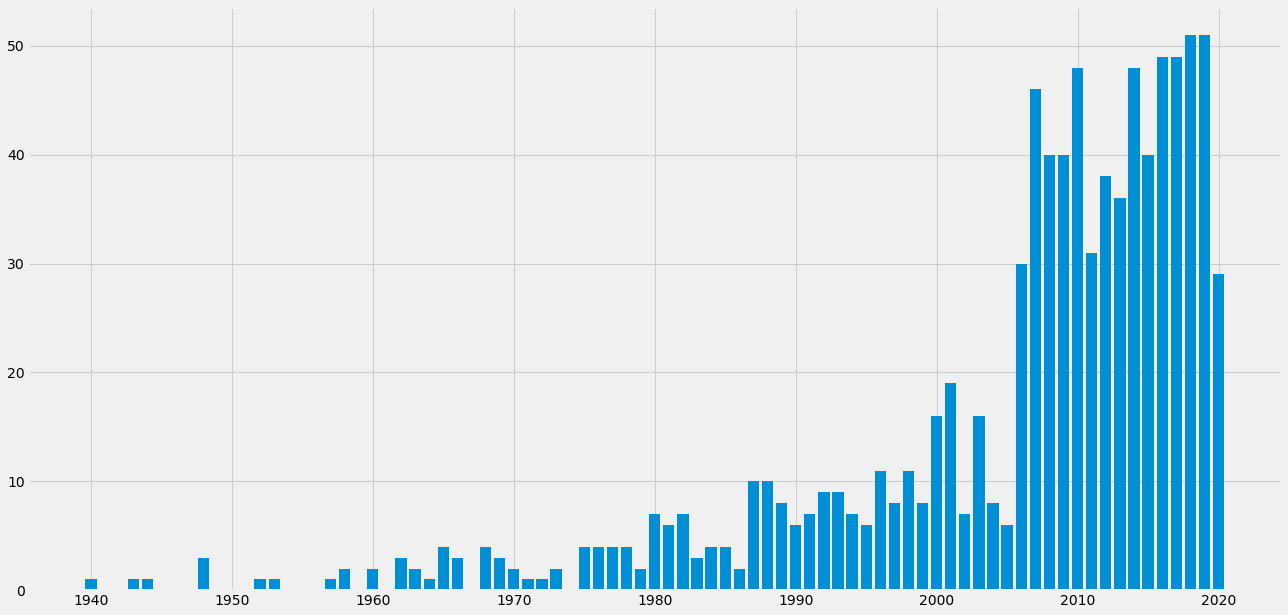

In [18]:
with plt.style.context('fivethirtyeight'):
    plt.bar(c.keys(), c.values())

## 7. Load data into a `pandas` dataframe

In [19]:
import pandas as pd

In [20]:
results[0].__fields_cache__

OrderedDict([('id', id: String!),
             ('b_tit', bTit: String),
             ('producer', producer: String),
             ('program', program: FaroProgram),
             ('sport_doc', sportDoc: FaroSportDoc!),
             ('web_cms_ids', webCmsIds: [String!]!)])

In [21]:
df = pd.DataFrame([x.__json_data__ for x in results])

In [22]:
df

,program,bTit,sportDoc,id,webCmsIds,producer
0,{'sDatStart': '2018-02-02'},Hotelleriesuisse GR,"{'season': None, 'sportEventPaths': [], 'sport...",31135c2d-b305-4575-aba6-e3d681adbc6a,[e504d662-04ab-4a9c-85b1-6fbe66638aa0],RTR
1,{'sDatStart': '2017-12-29'},SRF 1 29.12.2017 04 - 05 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",3113653b-616d-4044-81ee-e66cd2b13390,[],None
2,{'sDatStart': '2018-03-06'},SRF Virus 06.03.2018 14 - 15 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",311367fc-30be-4bc2-8898-7bb1063a2a5c,[],None
3,{'sDatStart': '1993-11-28'},Regionaljournal ZH\/SH 19931128,"{'season': None, 'sportEventPaths': [], 'sport...",3113762b-9b7f-4913-a4bc-72968108db12,[],None
4,{'sDatStart': None},None,"{'season': None, 'sportEventPaths': [], 'sport...",3113768b-bf35-4e55-a19c-76d9bfea5237,[],EVN/RTR
...,...,...,...,...,...,...
995,{'sDatStart': '2020-01-01'},SRF Musikwelle 01.01.2020 00-01 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",cc165d6f-d6bb-43f7-bad6-c5e4f270295b,[],None
996,{'sDatStart': '2019-06-09'},SRF Virus 09.06.2019 08 - 09 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",cc166522-dbf0-4bea-910f-ee3ae58ccad1,[],None
997,{'sDatStart': '2001-11-05'},Du lieber Bahnhof (aus: Erinnerungen an glückl...,"{'season': None, 'sportEventPaths': [], 'sport...",cc166801-ca00-4c77-a875-6675fadd827e,[],None
998,{'sDatStart': '2016-09-02'},Decider,"{'season': None, 'sportEventPaths': [], 'sport...",cc16688c-dad4-40c6-818a-09093e2136d9,[],RTR


## 8. Simple plotting with `pandas`

In [23]:
df.producer.describe()

count     490
unique     94
top       SRF
freq      158
Name: producer, dtype: object

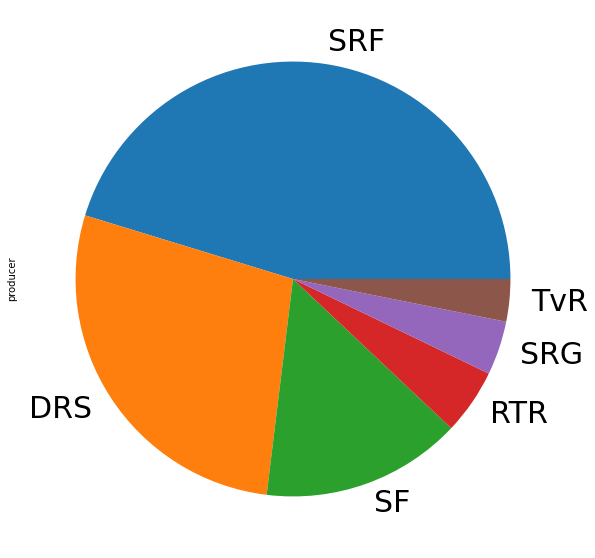

In [24]:
(df
 .groupby('producer')
 .filter(lambda x: len(x) > 10)
 .producer
 .value_counts()
 .plot
 .pie(fontsize=30));

## 9. Analysis of nested entries

In [25]:
pd.json_normalize(df.sportDoc).dropna().head()

,season,sportEventPaths,sportPaths
9,1998,[],[]
35,2007,[¦int¦Weltmeisterschaft¦],[¦Ski Alpin¦]
36,2017,[¦int¦Weltmeisterschaft¦],[¦Ski Alpin¦]
76,2015-2016,[¦nat¦Schweizermeisterschaft¦],[¦Fussball¦]
88,2009-2010,[¦nat¦Schweizermeisterschaft¦Playoff¦Playoff H...,[¦Wintersport¦Eishockey¦]


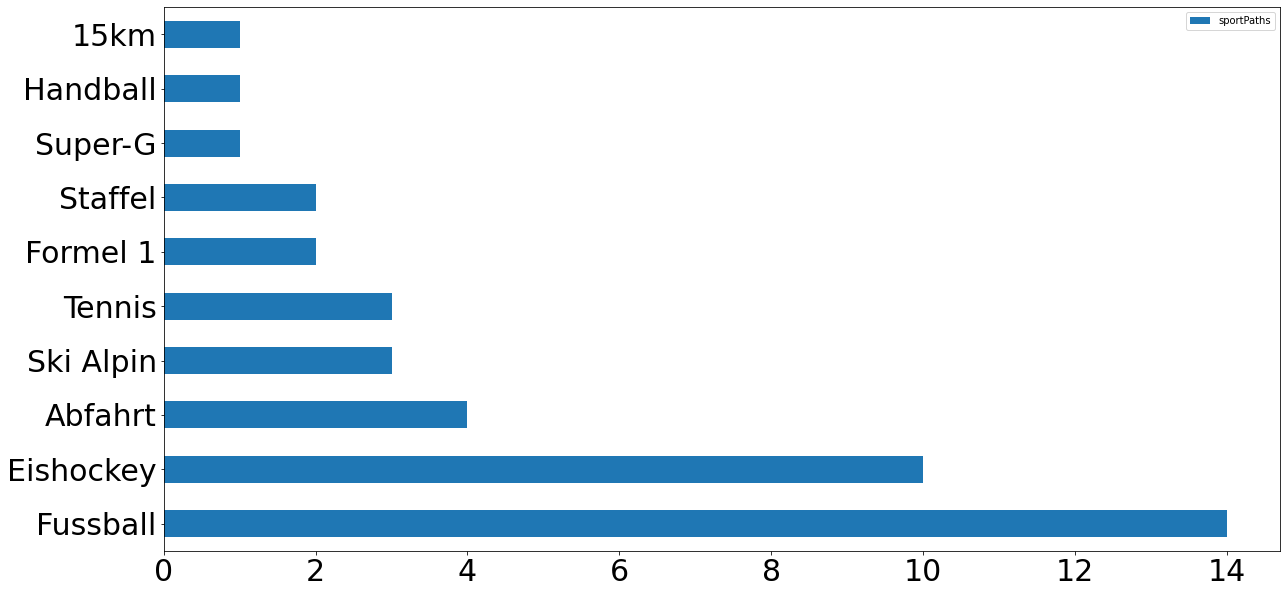

In [26]:
(pd
 .json_normalize(df.sportDoc)                # normalize sport doc entries
 .dropna()                                   # remove empty entries
 .sportPaths.explode()                       # explode array
 .str.split('¦').str[-2]                     # split by symbol and select 2nd to last
 .value_counts()                             # count occurrences
 .to_frame()                                 # transform to data frame
 .sort_values('sportPaths', ascending=False) # sort by occurrence
 .head(10)                                   # pick top 10
 .plot.barh(y='sportPaths', fontsize=30));   # plot as a horizontal bar chart